n1 = 5, n2 = 9 th = 0.95

Merging Technique on hough lines
Determine lines on remaining CC of subset 1

In [107]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import math


from Processing import *
from ImageHandler import *
from GeometryProcessing import *
from ImageProcessing import *
from globalVar import *

In [108]:
rcParams['figure.figsize'] = 7, 14

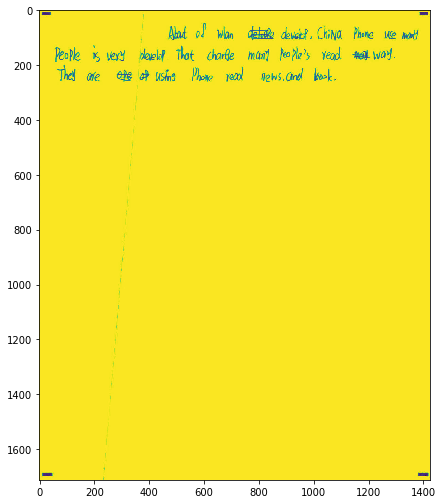

In [170]:
image = loadImage('../Dataset/600000080.jpg')
plt.imshow(image);

In [171]:
# Find components and calc avg height of components, assume it equal to avg character width.
# Divide components into 3 subsets based on simple conditions

(labels, avg_height, centroids, stats) = findComponents(image)
((centroids1, stats1), (centroids2, stats2), (centroids3, stats3)) = divide(centroids, stats, avg_height);

'Found 252 components with height 26.428571428571427 in image'

'Found 83 in subset 1, 3 in subset 2, and 166 in subset 3'

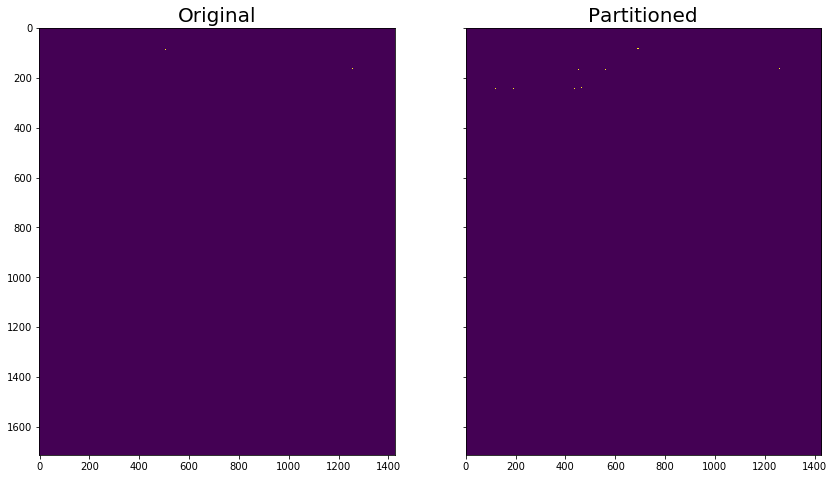

In [172]:
# Divide subset1 components into blocks of width aw and find their centroid. 

centroidP, mapP = partitionCC(stats1, int (avg_height));

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 28), sharex=True, sharey=True)

ax = axes.ravel()
ax[0].imshow(showCentroids(image, centroids1));
ax[0].set_title('Original', fontsize=20);

ax[1].imshow(showCentroids(image, centroidP));
ax[1].set_title('Partitioned', fontsize=20);

'Calculated 2523 lines'

'Showing...'

55 15


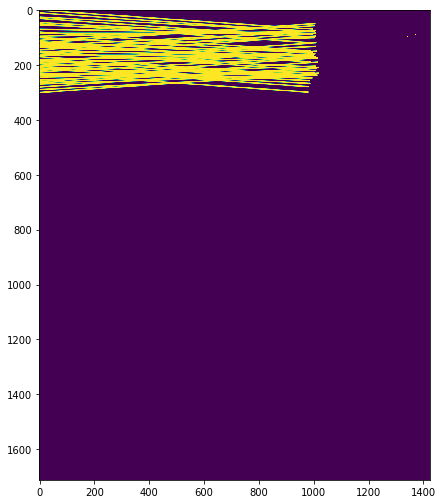

In [173]:
# Perform Hough transform on this with given parameters.
lines = [];
threshold = 10;
while (len(lines) < 4 or len(lines) > 70) and threshold < 500:
    lines = findHoughLines(showCentroids(image, centroidP), None, avg_height, threshold, 10, 40)
    threshold += 5;
if len(lines) < 4 and len(lines) > 100:
    print ('Empty')
    
print (len(lines), threshold);
init(lines, centroidP);

In [ ]:
### Make a lookup array mapping partition to its cc
# Check dist of partition from primary line
# Find the CC of that partition from mapping
# If dist of that partition is within +-0.5p then increment value of that CC else decrement
# Discard all CC having +ve value and map to find partition being discarded
# repeat step unless max contri cell < n1
# if n2 > conti > n1, then cell must be within 2 degree from first found cell.

n = 1000;
selLines = [];
while (True):
    lineP, pos, n = findPrimaryCell(lines, centroidP);
    print ("\n Contribution " + str(n), end= " ");
    if n < 5:
        break;
    elif n < 9:
        pTheta = math.radians(selLines[0][1]);
        theta = math.radians(lineP[1]);
        if (not (theta <= pTheta + 2 and theta >= pTheta - 2)):
            continue;
        print ("Low Contribution " + str(n), end = " ");
    
    centroidPN, count = discardPartition(lineP, np.copy(centroidP), centroids1, mapP)
    
    if (count == 0):
        break;
    
    print ("Discarded " + str(count) + " centroids");
    
    centroidP = np.copy(centroidPN);
    selLines.append(lineP);

print ("\n" + str(len(selLines)) + " lines selected");

In [102]:
getIntersections(selLines, image)

12


12

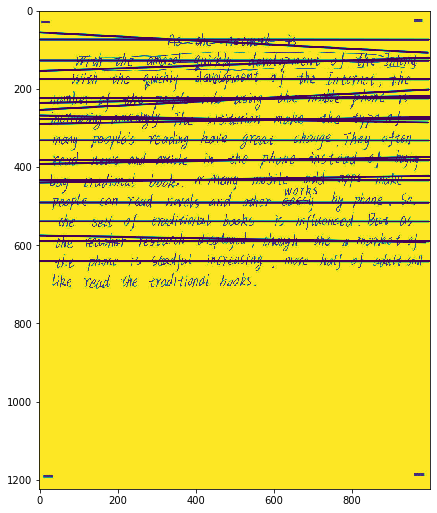

In [104]:
showLines(selLines, image)

In [139]:
len(centroidP) / 15

106.13333333333334